In [1]:

import pandas as pd 
import json
import numpy as np
import networkx as nx
import scipy
from scipy import sparse
from scipy.sparse import csc_matrix
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length,read_edgelist, set_node_attributes
from sklearn.metrics import average_precision_score,recall_score,precision_score,accuracy_score
import os
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import time
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from utlis import get_spectrum_embedding,load_data
from sklearn import preprocessing
from scipy.sparse.linalg import inv,eigs
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.sparse import csc_matrix
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score,recall_score,precision_score,accuracy_score
from plot_utlis import scatter_plot
from train_utlis import train,evaluate, loss,accuracy,get_train_test_set,fit_predict_lr,get_tsne_results
from models import *
from tqdm import tqdm,tqdm_notebook
from utlis import *

# Dataset Statistics

In [8]:
DATASET=['cora','citeseer','pubmed','github_user']
for dataset_str in DATASET:
    G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)

    print("Train, Val, Test Dataset Size for dataset {}".format(dataset_str))
    print("Training set {}, Validation Set {}, Test Set {}".format(len(idx_train),len(idx_val),len(idx_test)))

Train, Val, Test Dataset Size for dataset cora
Training set 140, Validation Set 500, Test Set 1000
Train, Val, Test Dataset Size for dataset citeseer
Training set 120, Validation Set 500, Test Set 1000
Train, Val, Test Dataset Size for dataset pubmed
Training set 60, Validation Set 500, Test Set 1000
Train, Val, Test Dataset Size for dataset github_user
Training set 7539, Validation Set 30161, Test Set 30161


# Toy Dataset

In [229]:
data,features,labels=load_data('karate4')
A = nx.adjacency_matrix(data)
A_norm = preprocess_adj(A)
n_labels=len(set(labels))

In [230]:
#A_norm=sparse_mx_to_torch_sparse_tensor(A)

In [233]:
labels=torch.LongTensor(labels)
features=sparse.csr_matrix(np.eye(*A.shape)).todense()



features=torch.FloatTensor(features)

In [234]:
idx_train=torch.LongTensor([0,33,6,27])
idx_test=torch.LongTensor(range(34))

In [261]:


class ToyGCN(nn.Module):
    def __init__(self, adj, nfeat, nhid, nclass, dropout, res_connection=True,get_hidden=False):
        super(ToyGCN, self).__init__()
        self.adj = adj
        self.gc1 = GCNLayer(self.adj, nfeat, nhid, res_connection=res_connection)
        self.gc2 = GCNLayer(self.adj, nhid, 2, res_connection=res_connection)
        self.gc3 = GCNLayer(self.adj, 2, nclass, res_connection=res_connection)
        self.dropout_rate = dropout
        self.relu = nn.ReLU()
        self.get_hidden=get_hidden
        

    def forward(self, x):
        x = self.gc1(x)
        x = self.relu(x)
        #x = F.dropout(x, self.dropout_rate, self.training)
        hidden = self.gc2(x)
        x = self.relu(hidden)
        
        #x = F.dropout(x, self.dropout_rate, self.training)
        x = self.gc3(x)
        
        if self.get_hidden:
            return x,hidden
        return x

# class Graph_Conv(nn.Module):
#     def __init__(self, adj,nfeat, nhid, nclass, dropout,res_connection=True,get_hidden=False):
#         super(Graph_Conv, self).__init__()
#         self.adj=adj
#         self.gc1 = GCNLayer(self.adj,nfeat, nhid,res_connection=res_connection)
#         self.gc2 = GCNLayer(self.adj,nhid, nclass,res_connection=res_connection)
# #         self.gc3 = GCNLayer(self.adj,2, nclass,res_connection=res_connection)
#         self.dropout_rate = dropout
#         self.relu=nn.ReLU()
#         self.loss_fuc=nn.CrossEntropyLoss(reduction='mean')
#         self.get_hidden=False
        

#     def forward(self, x):
#         x = self.relu(self.gc1(x))
# #         x =F.dropout(x, self.dropout_rate, self.training)
# #         nf = self.relu(self.gc2(x))
# #         print(nf.shape)
#         x =F.dropout(x, self.dropout_rate, self.training)
#         x = self.gc2(x)
#         return x,x
    
      

In [ ]:
def train_sp(model,features,idx_train,labels,optimizer):
  
    model.train()
    if model.get_hidden:
        output,hidden = model(features)
    else:
        output= model(features)
        
    loss_train=loss(output,labels,idx_train)
    acc_train = accuracy(output, labels,idx_train)
    optimizer.zero_grad()
    loss_train.backward()
    
    optimizer.step()
    
    if model.get_hidden:
        return loss_train.item(),acc_train.item(),output,hidden
   
    return loss_train.item(),acc_train.item(),output


def evaluate_sp(model,features,idx,labels):
    model.eval()
    if model.get_hidden:
        output,hidden = model(features)
    else:
        output= model(features)

    loss_ =loss(output,labels,idx)
    acc_ = accuracy(output, labels,idx)
    
    
    if model.get_hidden:
        return loss_.item(),acc_.item(),output,hidden

    return loss_.item(),acc_.item(),output


In [265]:

no_cuda= False,
seed=42
epochs=300
lr=0.02
weight_decay=0
hidden=32
dropout=0
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=5000


model = ToyGCN(adj=A_norm,nfeat=features.shape[1],
            nhid=hidden,
            nclass=labels.max().item() + 1,
            dropout=dropout,res_connection=True,get_hidden=True).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train model
t_total = time.time()

min_val_loss=float('inf')
feature_representation=[]
_,_,_,hidden=evaluate_sp(model,features,idx_train,labels)
feature_representation.append(hidden)
for epoch in tqdm_notebook(range(epochs)):
    loss_train,acc_train,output,hidden=train_sp(model,features,idx_test,labels,optimizer)
    feature_representation.append(hidden)
    if not fast_training:
        
        loss_val,acc_val,output,hidden=evaluate_sp(model,features,idx_test,labels)
  
#         print('Eval: ,loss_val: {:.4f},acc_val: {:.4f}\n'.format(loss_val,acc_val),end="")
        if loss_val<min_val_loss:
          epoch_no_improvement=0
          min_val_loss = loss_val
        else:
          epoch_no_improvement+=1
        
        if epoch_no_improvement==early_stop_epoch:
          print('Early Stop at Epoch %d'%(epoch))
          break
        #print()
          
print("Optimization Finished!")
print("Total Training time elapsed: {:.4f}s".format(time.time() - t_total))


#test
print("Start Inference:")


loss_trn,acc_trn,_,hidden=evaluate_sp(model,features,idx_test,labels)
print('Train:','loss;: {:.4f}'.format( loss_trn),
          'acc: {:.4f}'.format(acc_trn))


loss_test,acc_test,_,_=evaluate_sp(model,features,idx_test,labels)
print('Test:','loss;: {:.4f}'.format( loss_test),
          'acc: {:.4f}'.format(acc_test))




Optimization Finished!
Total Training time elapsed: 0.5695s
Start Inference:
Train: loss;: 0.0016 acc: 1.0000
Test: loss;: 0.0016 acc: 1.0000


In [267]:
def draw( i,epoch):
#     if epoch is None:
#         epoch = len(feature_representations) - 1

    
    n_categroy=n_labels
    color_list = ['#ff6a00','#ffdd00','#DF2E2E',"#2E51DF"]
    node_list=data.nodes()


    pos = {}
    number_of_points=feature_representation[0].size(0)
     
    for v in range(number_of_points):
        pos[v] = feature_representation[ i][v].detach().numpy()
#     X = feature_representation[i].detach().numpy()
#     X_embedded = TSNE(n_components=2).fit_transform(X)
#     for v in range(number_of_points):
#         pos[v] = X_embedded[v]
    
    ax.cla()
    ax.axis('off')
    #ax.set_title('Epoch: %d' % i)
    ax.set_title('Epoch %d'%(int( epoch)))
    label_names= ['C'+str(i) for i in range(n_labels)]
    

    for i_cate in range(n_categroy):
        nx.draw_networkx(data, pos, nodelist= [n for j,n in enumerate(node_list) if labels[j]==i_cate],node_color=color_list[i_cate],
                with_labels=True, node_size=50, ax=ax,font_size=5)
    
    
    
    nx.draw_networkx_edges(data, pos,width=1,alpha=1,edge_color='#DFDEDE')
    nx.draw_networkx_nodes(data, pos, nodelist=[0], node_size=350,node_color = color_list[0])
    nx.draw_networkx_nodes(data, pos, nodelist=[33], node_size=350,node_color = color_list[1])
    nx.draw_networkx_nodes(data, pos, nodelist=[6], node_size=350,node_color = color_list[2])
    nx.draw_networkx_nodes(data, pos, nodelist=[27], node_size=350,node_color = color_list[3])

In [ ]:

    
    
for i,epoch in enumerate([0,50,100,150,200,250,300]):
    fig = plt.figure(dpi=150)
    fig.clf()
    ax = fig.subplots()
    draw(i,epoch)
    plt.legend(loc=0, fontsize = 'x-small')
    plt.axis('on')
    plt.show()
    #plt.savefig("figure_kara_4label/epoch_%d.jpg"%(int(i)))
 

## Genearate Video

In [ ]:

from matplotlib import animation, rc
from IPython.display import HTML


In [269]:
# plt.close()
# from matplotlib import animation, rc
# # fig = plt.figure(dpi=150)
# # fig.clf()
# # def anim_init():
# #     fig.clear()
# ani = animation.FuncAnimation(fig, draw, frames=list(range(0,50)), interval=100,repeat_delay=1000)
# from IPython.display import HTML
# rc('animation', html='html5')
# HTML(ani.to_html5_video())


# Valina GCN

In [9]:
  
def train(idx_train):
  
    model.train()
   
    output = model(features)
    
    loss_train=loss(output,labels,idx_train)
    acc_train = accuracy(output, labels,idx_train)
    optimizer.zero_grad()
    loss_train.backward()
    
    optimizer.step()
   
    return loss_train.item(),acc_train.item()


def evaluate(idx):
    model.eval()
    output = model(features)
    loss_ =loss(output,labels,idx)
    acc_ = accuracy(output, labels,idx)

    return loss_.item(),acc_.item()



In [11]:
DATASET=['cora','citeseer','pubmed']

no_cuda= False,
seed=42
epochs=400
lr=0.01
weight_decay=5e-4
hidden=16
dropout=0.5
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10


for dataset_str in DATASET:
    print()
    print(dataset_str)
    G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)
    model = SimpleGCN(adj=A_norm,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=False).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)



    # Train model
    t_total = time.time()
    epoch_no_improvement=0
    min_val_loss=float('inf')

    init_loss_train, init_acc_train=evaluate(idx_train)
    training_loss_list=[init_loss_train]
    training_error_list=[1-init_acc_train]

    if not fast_training:
        init_loss_val, init_acc_val=evaluate(idx_val)
        validation_loss_list=[init_loss_val]
        validation_error_list=[1-init_acc_val]

    for epoch in tqdm_notebook(range(epochs)):

        loss_train,acc_train=train(idx_train)
        training_loss_list.append(loss_train)
        training_error_list.append(1-acc_train)
        #print('Epoch: {:04d} ,loss_train: {:.4f},acc_train: {:.4f}\n'.format(epoch+1,loss_train,acc_train),end="")

        if not fast_training:

            loss_val,acc_val=evaluate(idx_val)
            validation_loss_list.append(loss_val)
            validation_error_list.append(1-acc_val)

           #print('Eval: ,loss_val: {:.4f},acc_val: {:.4f}\n'.format(loss_val,acc_val),end="")
            if loss_val<min_val_loss:
              epoch_no_improvement=0
              min_val_loss = loss_val
            else:
              epoch_no_improvement+=1

            if epoch_no_improvement==early_stop_epoch:
              print('Early Stop at Epoch %d'%(epoch))
              break
            #print()


    print("Optimization Finished!")
    print("Total Training time elapsed: {:.4f}s".format(time.time() - t_total))


    #test
    print("Start Inference:")


    loss_trn,acc_trn=evaluate(idx_train)
    print('Train:','loss;: {:.4f}'.format( loss_trn),
              'acc: {:.4f}'.format(acc_trn))


    t_total = time.time()
    loss_test,acc_test=evaluate(idx_test)
    print('Test:','loss;: {:.4f}'.format( loss_test),
              'acc: {:.4f}'.format(acc_test))
    print("Total Inference time elapsed: {:.4f}s".format(time.time() - t_total))



cora


Early Stop at Epoch 192
Optimization Finished!
Total Training time elapsed: 4.0947s
Start Inference:
Train: loss;: 0.2390 acc: 1.0000
Test: loss;: 0.7783 acc: 0.8100
Total Inference time elapsed: 0.0096s

citeseer



Early Stop at Epoch 249
Optimization Finished!
Total Training time elapsed: 21.0264s
Start Inference:
Train: loss;: 0.3362 acc: 0.9833
Test: loss;: 1.0484 acc: 0.7120
Total Inference time elapsed: 0.0388s

pubmed


Early Stop at Epoch 169
Optimization Finished!
Total Training time elapsed: 20.2437s
Start Inference:
Train: loss;: 0.1227 acc: 1.0000
Test: loss;: 0.5827 acc: 0.7910
Total Inference time elapsed: 0.0531s



github_user


Early Stop at Epoch 227
Optimization Finished!
Total Training time elapsed: 517.7949s
Start Inference:
Train: loss;: 0.4439 acc: 0.7762
Test: loss;: 0.5156 acc: 0.7507
Total Inference time elapsed: 1.0861s


# GCN with ResCon

In [6]:
  
def train(idx_train):
  
    model.train()
   
    output = model(features)
    
    loss_train=loss(output,labels,idx_train)
    acc_train = accuracy(output, labels,idx_train)
    optimizer.zero_grad()
    loss_train.backward()
    
    optimizer.step()
   
    return loss_train.item(),acc_train.item()


def evaluate(idx):
    model.eval()
    output = model(features)
    loss_ =loss(output,labels,idx)
    acc_ = accuracy(output, labels,idx)

    return loss_.item(),acc_.item()



In [15]:
DATASET=['cora','citeseer','pubmed']

no_cuda= False,
seed=42
epochs=400
lr=0.01
weight_decay=5e-4
hidden=32
dropout=0.5
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10


for dataset_str in DATASET:
    print()
    print(dataset_str)
    G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)

    model = MutipleGCN(adj=A_norm,ngcu=2,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=True).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)



    # Train model
    t_total = time.time()
    epoch_no_improvement=0
    min_val_loss=float('inf')

    init_loss_train, init_acc_train=evaluate(idx_train)
    training_loss_list=[init_loss_train]
    training_error_list=[1-init_acc_train]

    if not fast_training:
        init_loss_val, init_acc_val=evaluate(idx_val)
        validation_loss_list=[init_loss_val]
        validation_error_list=[1-init_acc_val]

    for epoch in tqdm_notebook(range(epochs)):

        loss_train,acc_train=train(idx_train)
        training_loss_list.append(loss_train)
        training_error_list.append(1-acc_train)
        #print('Epoch: {:04d} ,loss_train: {:.4f},acc_train: {:.4f}\n'.format(epoch+1,loss_train,acc_train),end="")

        if not fast_training:

            loss_val,acc_val=evaluate(idx_val)
            validation_loss_list.append(loss_val)
            validation_error_list.append(1-acc_val)

           #print('Eval: ,loss_val: {:.4f},acc_val: {:.4f}\n'.format(loss_val,acc_val),end="")
            if loss_val<min_val_loss:
              epoch_no_improvement=0
              min_val_loss = loss_val
            else:
              epoch_no_improvement+=1

            if epoch_no_improvement==early_stop_epoch:
              print('Early Stop at Epoch %d'%(epoch))
              break
            #print()


    print("Optimization Finished!")
    print("Total Training time elapsed: {:.4f}s".format(time.time() - t_total))


    #test
    print("Start Inference:")


    loss_trn,acc_trn=evaluate(idx_train)
    print('Train:','loss;: {:.4f}'.format( loss_trn),
              'acc: {:.4f}'.format(acc_trn))


    t_total = time.time()
    loss_test,acc_test=evaluate(idx_test)
    print('Test:','loss;: {:.4f}'.format( loss_test),
              'acc: {:.4f}'.format(acc_test))
    print("Total Inference time elapsed: {:.4f}s".format(time.time() - t_total))



cora


Early Stop at Epoch 153
Optimization Finished!
Total Training time elapsed: 4.7659s
Start Inference:
Train: loss;: 0.0437 acc: 1.0000
Test: loss;: 0.7461 acc: 0.7770
Total Inference time elapsed: 0.0120s

citeseer


Early Stop at Epoch 163
Optimization Finished!
Total Training time elapsed: 17.1050s
Start Inference:
Train: loss;: 0.0586 acc: 1.0000
Test: loss;: 0.9238 acc: 0.7170
Total Inference time elapsed: 0.0439s

pubmed


Early Stop at Epoch 69
Optimization Finished!
Total Training time elapsed: 9.4488s
Start Inference:
Train: loss;: 0.0334 acc: 1.0000
Test: loss;: 0.6090 acc: 0.7650
Total Inference time elapsed: 0.0575s



github_user


Early Stop at Epoch 24
Optimization Finished!
Total Training time elapsed: 62.7231s
Start Inference:
Train: loss;: 0.4436 acc: 0.7420
Test: loss;: 0.5730 acc: 0.7416
Total Inference time elapsed: 1.1013s


# GAT

In [16]:
no_cuda= False,
seed=42
epochs=200
lr=0.005
weight_decay=1e-3
hidden=8
dropout=0.6
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10
nheads=8

In [17]:
for dataset_str in DATASET:

    G,_, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)
    A= get_adjacency_matrix(G)
    A=A + sparse.eye(A.shape[0])
    A_norm=sparse_mx_to_torch_sparse_tensor(A)


    model = GAT(adj=A_norm,nheads=nheads,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=True,last_layer_mh=False).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)



    # Train model
    t_total = time.time()
    epoch_no_improvement=0
    min_val_loss=float('inf')

    init_loss_train, init_acc_train=evaluate(idx_train)
    training_loss_list=[init_loss_train]
    training_error_list=[1-init_acc_train]

    if not fast_training:
        init_loss_val, init_acc_val=evaluate(idx_val)
        validation_loss_list=[init_loss_val]
        validation_error_list=[1-init_acc_val]

    for epoch in tqdm_notebook(range(epochs)):

        loss_train,acc_train=train(idx_train)
        training_loss_list.append(loss_train)
        training_error_list.append(1-acc_train)
        #print('Epoch: {:04d} ,loss_train: {:.4f},acc_train: {:.4f}\n'.format(epoch+1,loss_train,acc_train),end="")

        if not fast_training:

            loss_val,acc_val=evaluate(idx_val)
            validation_loss_list.append(loss_val)
            validation_error_list.append(1-acc_val)

           #print('Eval: ,loss_val: {:.4f},acc_val: {:.4f}\n'.format(loss_val,acc_val),end="")
            if loss_val<min_val_loss:
              epoch_no_improvement=0
              min_val_loss = loss_val
            else:
              epoch_no_improvement+=1

            if epoch_no_improvement==early_stop_epoch:
              print('Early Stop at Epoch %d'%(epoch))
              break
            #print()


    print("Optimization Finished!")
    print("Total Training time elapsed: {:.4f}s".format(time.time() - t_total))


    #test
    print("Start Inference:")


    loss_trn,acc_trn=evaluate(idx_train)
    print('Train:','loss;: {:.4f}'.format( loss_trn),
              'acc: {:.4f}'.format(acc_trn))


    t_total = time.time()
    loss_test,acc_test=evaluate(idx_test)
    print('Test:','loss;: {:.4f}'.format( loss_test),
              'acc: {:.4f}'.format(acc_test))
    print("Total Inference time elapsed: {:.4f}s".format(time.time() - t_total))



Optimization Finished!
Total Training time elapsed: 52.2657s
Start Inference:
Train: loss;: 0.2831 acc: 0.9929
Test: loss;: 0.8154 acc: 0.8150
Total Inference time elapsed: 0.0556s



Optimization Finished!
Total Training time elapsed: 104.6717s
Start Inference:
Train: loss;: 0.4135 acc: 1.0000
Test: loss;: 1.1639 acc: 0.6990
Total Inference time elapsed: 0.0592s


Early Stop at Epoch 138
Optimization Finished!
Total Training time elapsed: 883.8949s
Start Inference:
Train: loss;: 0.1630 acc: 1.0000
Test: loss;: 0.6077 acc: 0.7740
Total Inference time elapsed: 0.1997s


In [11]:
no_cuda= False,
seed=42
epochs=200
lr=0.005
weight_decay=1e-3
hidden=8
dropout=0.6
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10
nheads=8
DATASET=['github_user']

In [ ]:
for dataset_str in DATASET:

    G,_, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)
    A= get_adjacency_matrix(G)
    A=A + sparse.eye(A.shape[0])
    A_norm=sparse_mx_to_torch_sparse_tensor(A)


    model = GAT(adj=A_norm,nheads=nheads,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=True,last_layer_mh=False).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)



    # Train model
    t_total = time.time()
    epoch_no_improvement=0
    min_val_loss=float('inf')

    init_loss_train, init_acc_train=evaluate(idx_train)
    training_loss_list=[init_loss_train]
    training_error_list=[1-init_acc_train]

    if not fast_training:
        init_loss_val, init_acc_val=evaluate(idx_val)
        validation_loss_list=[init_loss_val]
        validation_error_list=[1-init_acc_val]

    for epoch in tqdm_notebook(range(epochs)):

        loss_train,acc_train=train(idx_train)
        training_loss_list.append(loss_train)
        training_error_list.append(1-acc_train)
        #print('Epoch: {:04d} ,loss_train: {:.4f},acc_train: {:.4f}\n'.format(epoch+1,loss_train,acc_train),end="")

        if not fast_training:

            loss_val,acc_val=evaluate(idx_val)
            validation_loss_list.append(loss_val)
            validation_error_list.append(1-acc_val)

           #print('Eval: ,loss_val: {:.4f},acc_val: {:.4f}\n'.format(loss_val,acc_val),end="")
            if loss_val<min_val_loss:
              epoch_no_improvement=0
              min_val_loss = loss_val
            else:
              epoch_no_improvement+=1

            if epoch_no_improvement==early_stop_epoch:
              print('Early Stop at Epoch %d'%(epoch))
              break
            #print()


    print("Optimization Finished!")
    print("Total Training time elapsed: {:.4f}s".format(time.time() - t_total))


    #test
    print("Start Inference:")


    loss_trn,acc_trn=evaluate(idx_train)
    print('Train:','loss;: {:.4f}'.format( loss_trn),
              'acc: {:.4f}'.format(acc_trn))


    t_total = time.time()
    loss_test,acc_test=evaluate(idx_test)
    print('Test:','loss;: {:.4f}'.format( loss_test),
              'acc: {:.4f}'.format(acc_test))
    print("Total Inference time elapsed: {:.4f}s".format(time.time() - t_total))


KeyboardInterrupt: 

# Plotting of Neural Model

In [14]:
  
def train(idx_train):
  
    model.train()
   
    output = model(features)
    
    loss_train=loss(output,labels,idx_train)
    acc_train = accuracy(output, labels,idx_train)
    optimizer.zero_grad()
    loss_train.backward()
    
    optimizer.step()
   
    return loss_train.item(),acc_train.item()


def evaluate(idx):
    model.eval()
    output = model(features)
    loss_ =loss(output,labels,idx)
    acc_ = accuracy(output, labels,idx)

    return loss_.item(),acc_.item()


def train_model():
    # Train model
    training_loss_list=[]
    training_error_list=[]
    validation_loss_list=[]
    validation_error_list=[]
        
    t_total = time.time()
    epoch_no_improvement=0
    min_val_loss=float('inf')

    init_loss_train, init_acc_train=evaluate(idx_train)
    training_loss_list=[init_loss_train]
    training_error_list=[1-init_acc_train]

    if not fast_training:
        init_loss_val, init_acc_val=evaluate(idx_val)
        validation_loss_list=[init_loss_val]
        validation_error_list=[1-init_acc_val]

    for epoch in tqdm_notebook(range(epochs)):

        loss_train,acc_train=train(idx_train)
        training_loss_list.append(loss_train)
        training_error_list.append(1-acc_train)
        #print('Epoch: {:04d} ,loss_train: {:.4f},acc_train: {:.4f}\n'.format(epoch+1,loss_train,acc_train),end="")
        loss_val,acc_val=evaluate(idx_val)
        validation_loss_list.append(loss_val)
        validation_error_list.append(1-acc_val)

    return [training_loss_list,validation_loss_list,training_error_list,validation_error_list]

In [ ]:
DATASET=['pubmed','github_user']


no_cuda= False,
seed=42
epochs=200
lr=0.01
weight_decay=5e-4
hidden=16
dropout=0.6
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10000
nheads=8


names=['GCN','GCN (residual)','GAT']
color_list=['red','green','blue']

for dataset_str in DATASET:
    plt.figure(figsize=(18,4))

    ax1=plt.subplot(141)
    ax2=plt.subplot(142)
    ax3=plt.subplot(143)
    ax4=plt.subplot(144)
    axes=[ax1,ax2,ax3,ax4]
    for  model_index in range(3):
        if model_index==0:
  
            G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)
            model = MutipleGCN(adj=A_norm,ngcu=2,nfeat=features.shape[1],
                        nhid=hidden,
                        nclass=labels.max().item() + 1,
                        dropout=dropout,res_connection=False).to(device=device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
        elif model_index==1:
  
            G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)

            model = MutipleGCN(adj=A_norm,ngcu=2,nfeat=features.shape[1],
                        nhid=hidden,
                        nclass=labels.max().item() + 1,
                        dropout=dropout,res_connection=True).to(device=device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
        else:
  
            G,A_norm, features, labels, idx_train,idx_test,idx_val=load_data(dataset_str)
            A= get_adjacency_matrix(G)
            A=A + sparse.eye(A.shape[0])
            A_norm=sparse_mx_to_torch_sparse_tensor(A)

            model = GAT(adj=A_norm,nheads=nheads,nfeat=features.shape[1],
                        nhid=hidden,
                        nclass=labels.max().item() + 1,
                        dropout=dropout,res_connection=True,last_layer_mh=False).to(device=device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
        #train_model    
        
        trn_statistics=train_model()
        x=range(len(trn_statistics[0]))
        for j in range(len(trn_statistics)):
            axes[j].plot(x, trn_statistics[j], label=names[model_index], marker=None,color=color_list[model_index])
    
    target_word1=['Loss','Loss','Error','Error']
    target_word2=['Training Loss','Validation Loss','Training Error','Validation Error']
    for j in range(4):
        axes[j].set_xlabel("Epoch")
        axes[j].set_ylabel(target_word1[j])
        axes[j].title.set_text(target_word2[j])
        axes[j].legend(loc=1)
        axes[j].set_xticks([0,50,100,150,200])
  
    plt.suptitle("{}".format(dataset_str.capitalize()),y=-0.01)
   
    plt.savefig("{}_three_model.jpg".format(dataset_str))
    #plt.show()
    

# Wall Clock Time

In [14]:

no_cuda= False,
seed=42
epochs=200
lr=0.01
weight_decay=5e-4
hidden=16
dropout=0.6
fast_training=False
device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
early_stop_epoch=10000
nheads=8


In [ ]:
def train_model_time(dataset_str,depth=None,res_connection=False):
    G,A_norm, features, labels, _,_,_=load_data(dataset_str)
    
    idx_train=np.arange(len(features))
    idx_train=torch.LongTensor(idx_train)
    
    def train(idx_train): 
        model.train()

        output = model(features)

        loss_train=loss(output,labels,idx_train)
        acc_train = accuracy(output, labels,idx_train)
        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()

        return loss_train.item(),acc_train.item()
    def evaluate(idx):
        model.eval()
        output = model(features)
        loss_ =loss(output,labels,idx)
        acc_ = accuracy(output, labels,idx)

        return loss_.item(),acc_.item()
    

    model = MutipleGCN(adj=A_norm,ngcu=depth,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=res_connection).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    
    t_start = time.time()
    for i in range(10):
        loss_train,acc_train=train(idx_train)
            
    training_time=(time.time() - t_start)/10
    
    t_start = time.time()
    for i in range(10):
        loss_val,acc_val=evaluate(idx_train)
    
    inference_time=(time.time() - t_start)/10
    
    return training_time,inference_time

def plot_runtime_analysis(dataset_str,ndepth_list):
    plt.figure(figsize=(10,6))
    ax1=plt.subplot(111)


    dataset_str=dataset_str
    train_with_res_temp=[]
    test_with_res_temp=[]
    test_without_res_temp=[]
    train_without_res_temp=[]
    for depth in ndepth_list:
        print(depth)

        trn_time1,tst_time1=train_model_time(dataset_str,depth=depth,res_connection=True)
        
        trn_time2,tst_time2=train_model_time(dataset_str,depth=depth,res_connection=False)
        
        train_with_res_temp.append(trn_time1)
        test_with_res_temp.append(tst_time1)
        train_without_res_temp.append(trn_time2)
        test_without_res_temp.append(tst_time2)


    x=range(1,len(ndepth_list)+1)
    ax1.plot(x, train_with_res_temp,'g-', label="Training (Residual)",marker='o')
    ax1.plot(x, test_with_res_temp,'r-', label="Inference (Residual)", marker='o')
    ax1.plot(x, train_without_res_temp,'b--', label="Training", marker='o')
    ax1.plot(x, test_without_res_temp,'y--',label="Inference", marker='o')

    ax1.set_xlabel("Number of Layers")
    ax1.set_ylabel("Time")
 
    ax1.legend(loc=2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(ndepth_list)
    if dataset_str=='github_user':
        ax1.title.set_text('GSN')
    else:
        ax1.title.set_text(dataset_str.capitalize())
    

    
    plt.savefig("run_time_plot_{}.jpg".format(dataset_str))
    #plt.show()
    return 


DATASET=['cora','citeseer','pubmed','github_user']
DEPTH_LIST=[1,2,3,4,5,10,20,50,100,200]

for name in DATASET:
    plot_runtime_analysis(dataset_str=name,ndepth_list=DEPTH_LIST)

1
2
3
4
5
10
20
50
100
200
1
2
3
4
5
10
20
50


In [ ]:
def train_gat_model(dataset_str,depth,res_connection=False):
    G,A_norm, features, labels, _,_,_=load_data(dataset_str)
    
    idx_train=np.arange(len(features))
    idx_train=torch.LongTensor(idx_train)
    
    def train(idx_train): 
        model.train()

        output = model(features)

        loss_train=loss(output,labels,idx_train)
        acc_train = accuracy(output, labels,idx_train)
        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()

        return loss_train.item(),acc_train.item()
    def evaluate(idx):
        model.eval()
        output = model(features)
        loss_ =loss(output,labels,idx)
        acc_ = accuracy(output, labels,idx)

        return loss_.item(),acc_.item()
    
    A= get_adjacency_matrix(G)
    A=A + sparse.eye(A.shape[0])
    A_norm=sparse_mx_to_torch_sparse_tensor(A)

    model = GAT(adj=A_norm,nheads=depth,nfeat=features.shape[1],
                nhid=hidden,
                nclass=labels.max().item() + 1,
                dropout=dropout,res_connection=True,last_layer_mh=False).to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    
    t_start = time.time()
    for i in range(10):
        loss_train,acc_train=train(idx_train)
            
    training_time=(time.time() - t_start)/10
    
    t_start = time.time()
    for i in range(10):
        loss_val,acc_val=evaluate(idx_train)
    
    inference_time=(time.time() - t_start)/10
    
    return training_time,inference_time    

4
5
8
10
15
20


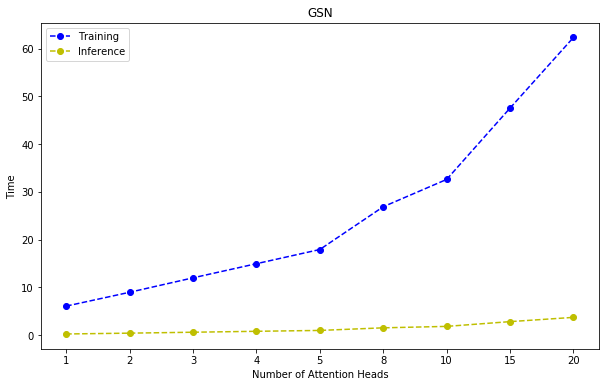

In [ ]:

def plot_runtime_analysis_forGAT(dataset_str,ndepth_list):
    plt.figure(figsize=(10,6))
    ax1=plt.subplot(111)

    dataset_str=dataset_str
    test_without_res_temp=[]
    train_without_res_temp=[]
    for depth in ndepth_list:
        print(depth)

        trn_time1,tst_time1=train_gat_model(dataset_str,depth=depth,res_connection=False)
      
        
        train_without_res_temp.append(trn_time1)
        test_without_res_temp.append(tst_time1)
   

    x=range(1,len(ndepth_list)+1)

    ax1.plot(x, train_without_res_temp,'b--', label="Training", marker='o')
    ax1.plot(x, test_without_res_temp,'y--',label="Inference", marker='o')

    ax1.set_xlabel("Number of Attention Heads")
    ax1.set_ylabel("Time")
    if dataset_str=='github_user':
        ax1.title.set_text('GSN')
    else:
        ax1.title.set_text(dataset_str.capitalize())
    ax1.legend(loc=2)
    ax1.set_xticks(x)
    ax1.set_xticklabels(ndepth_list)
    
    
    plt.savefig("run_time_plot_GAT_{}.jpg".format(dataset_str))
    plt.show()
    return 
DATASET=['cora','citeseer','pubmed','github_user']
DEPTH_LIST=[1,2,3,4,5,8,10,15,20]

for name in DATASET:
    plot_runtime_analysis_forGAT(dataset_str=name,ndepth_list=DEPTH_LIST)